In [41]:
setwd("~/Upd-Germline-Genomics")
source("_targets.R")

In [42]:
library(egg)
library(GenomicRanges)
library(ggplot2)
library(grid)
library(gtable)

In [43]:
tar_load(
  c(
    repli.peaks_chr,
    matches("^chic.experiment.quantify_H3K(4|27|9)_(Germline|Somatic)_peakcalling.broad_chr$")
  )
)

In [44]:
write(deparse(cell_type_violin_colors), stdout())

c(Germline = "#96C586", Somatic = "#A97AAC")


In [45]:
list(Germline = "#96C586", Somatic = "#A97AAC")

$Germline
[1] "#96C586"

$Somatic
[1] "#A97AAC"

In [46]:
peaks <- repli.peaks_chr[[1]]
ov <- findOverlaps(peaks, chic.experiment.quantify_H3K4_Germline_peakcalling.broad_chr)
stopifnot(all(!duplicated(to(ov))))
data <- with(
  tribble(
    ~celltype, ~mark, ~track,
    "Germline", "H3K4me3", chic.experiment.quantify_H3K4_Germline_peakcalling.broad_chr,
    "Somatic", "H3K4me3", chic.experiment.quantify_H3K4_Somatic_peakcalling.broad_chr,
    "Germline", "H3K27me3", chic.experiment.quantify_H3K27_Germline_peakcalling.broad_chr,
    "Somatic", "H3K27me3", chic.experiment.quantify_H3K27_Somatic_peakcalling.broad_chr,
    "Germline", "H3K9me3", chic.experiment.quantify_H3K9_Germline_peakcalling.broad_chr,
    "Somatic", "H3K9me3", chic.experiment.quantify_H3K9_Somatic_peakcalling.broad_chr,
  ),
  tibble(
    celltype = celltype %>% factor(., unique(.)),
    mark = mark %>% factor(., unique(.)),
    track
  )
) %>%
  group_by(celltype, mark) %>%
  reframe(
    as_tibble(
      list(
        classification = ifelse(grepl("GermlineEarlier", names(peaks[from(ov)])), "GermlineEarlier", "GermlineLater"),
        seqnames = as.factor(seqnames(peaks)[from(ov)]),
        L2FC = track[[1]][to(ov)]$L2FC
      )
    )
  ) %>%
  print()


# A tibble: 2,397,666 × 5
   celltype mark    classification seqnames  L2FC
   <fct>    <fct>   <chr>          <fct>    <dbl>
 1 Germline H3K4me3 GermlineLater  2L       0.440
 2 Germline H3K4me3 GermlineLater  2L       0.473
 3 Germline H3K4me3 GermlineLater  2L       0.585
 4 Germline H3K4me3 GermlineLater  2L       0.559
 5 Germline H3K4me3 GermlineLater  2L       0.589
 6 Germline H3K4me3 GermlineLater  2L       0.501
 7 Germline H3K4me3 GermlineLater  2L       0.459
 8 Germline H3K4me3 GermlineLater  2L       0.232
 9 Germline H3K4me3 GermlineLater  2L       0.329
10 Germline H3K4me3 GermlineLater  2L       0.417
# ℹ 2,397,656 more rows


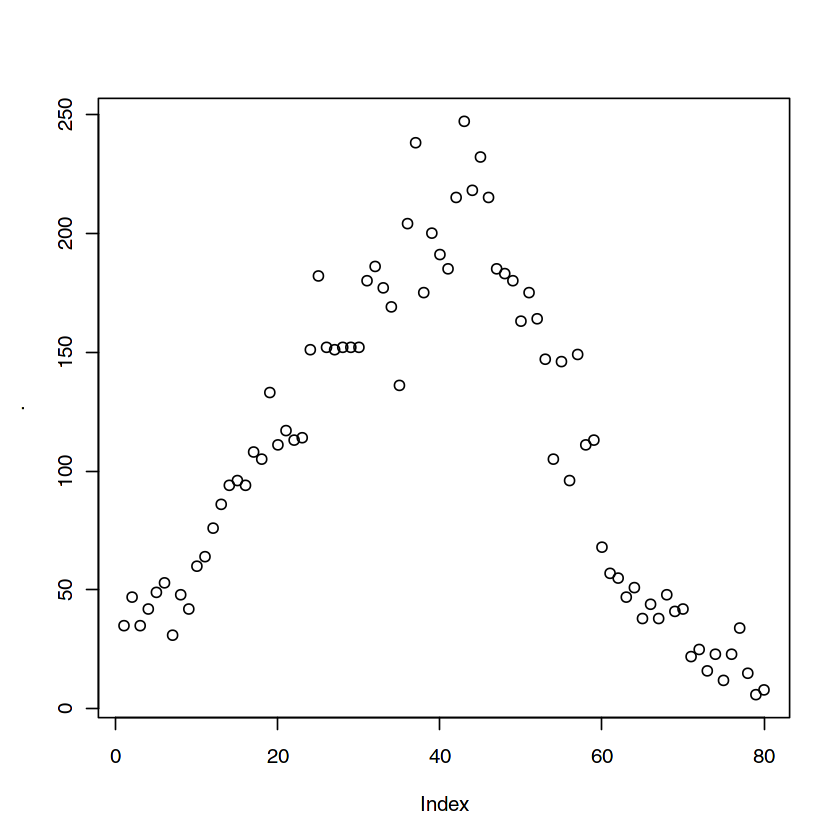

In [47]:
mutate(
  subset(data, !between(L2FC, -1e-5, 1e-5)),
  lvl = cut(L2FC, seq(-2, 2, by=0.05))
) %>%
  subset(seqnames == "Y") %>%
  pull(lvl) %>%
  table() %>%
  as.numeric() %>%
  plot()

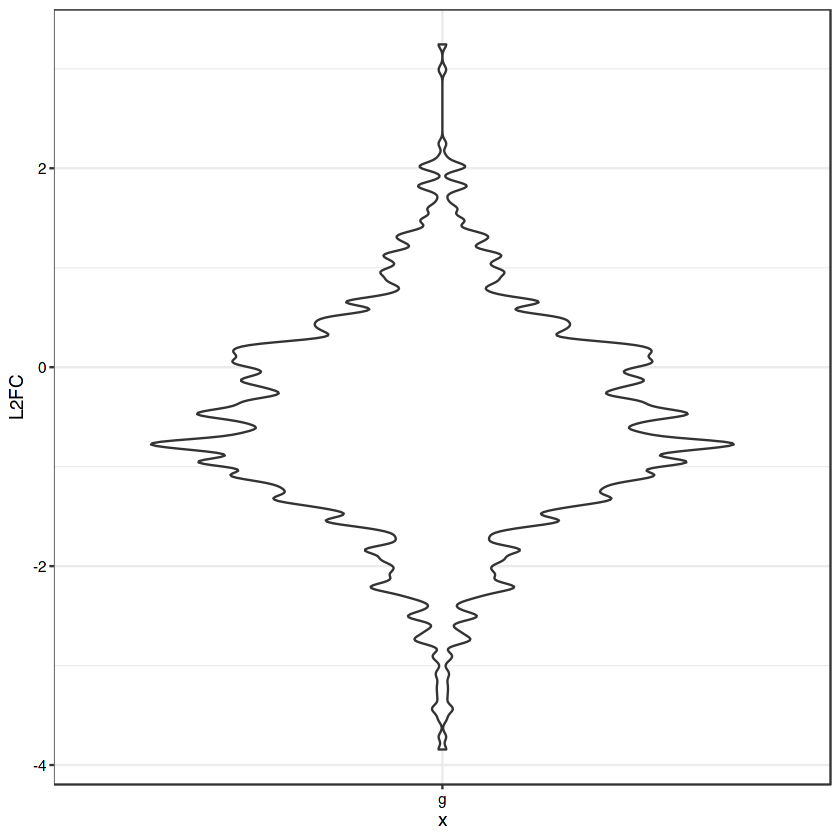

In [48]:
subset(
  data,
  celltype == "Germline" &
    mark == "H3K4me3" &
    seqnames == "Y" &
    classification == "GermlineLater" &
    !between(L2FC, -1e-4, 1e-4) &
    between(L2FC, -5, 5)
) %>%
  tibble(x = "g") %>%
  ggplot(aes(x, L2FC)) +
  geom_violin(bw = 0.04)

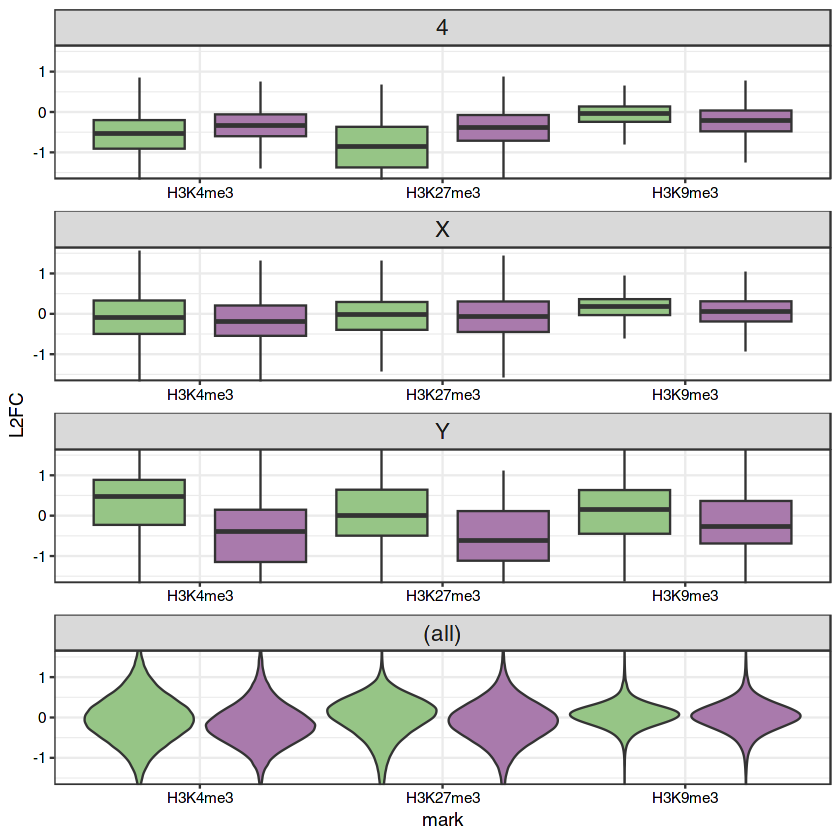

In [49]:
earlier <- subset(
  data,
  classification == "GermlineEarlier"
) %>%
  with(
    rbind(
      tibble(mark, L2FC, celltype, seqnames) %>%
        subset(seqnames %in% c("4", "X", "Y")) %>%
        mutate(seqnames = seqnames %>% factor(c("4", "X", "Y", "(all)"))),
      tibble(mark, L2FC, celltype, seqnames) %>%
        mutate(seqnames = "(all)")
    )
  ) %>%
  ggplot(
    aes(mark, L2FC, fill=celltype)
  ) +
  facet_wrap(vars(seqnames), scales = "free", ncol = 1) +
  geom_blank(
    data = cross_join(
      tibble(seqnames = c("4", "X", "Y", "(all)") %>% factor(., .), L2FC = 0),
      tibble(celltype = "Germline", mark = levels(data$mark) %>% factor(., .))
    )
  ) +
  geom_violin(
    data = \(data) data %>%
      subset(
        between(L2FC, -5, 5) &
          !between(L2FC, -1e-4, 1e-4) &
          seqnames == "(all)"
      ),
    bw = 0.05,
    scale = "width",
    position = position_dodge(width = 1)
  ) +
  geom_boxplot(
    data = \(data) data %>%
      subset(
        between(L2FC, -5, 5) &
          !between(L2FC, -1e-4, 1e-4) &
          seqnames != "(all)"
      ),
    outlier.shape = NA,
    position = position_dodge(width = 1)
  ) +
  scale_fill_manual(values = cell_type_violin_colors) +
  coord_cartesian(NULL, c(-1.5, 1.5)) +
  theme(
    legend.position = "none"
  )
earlier

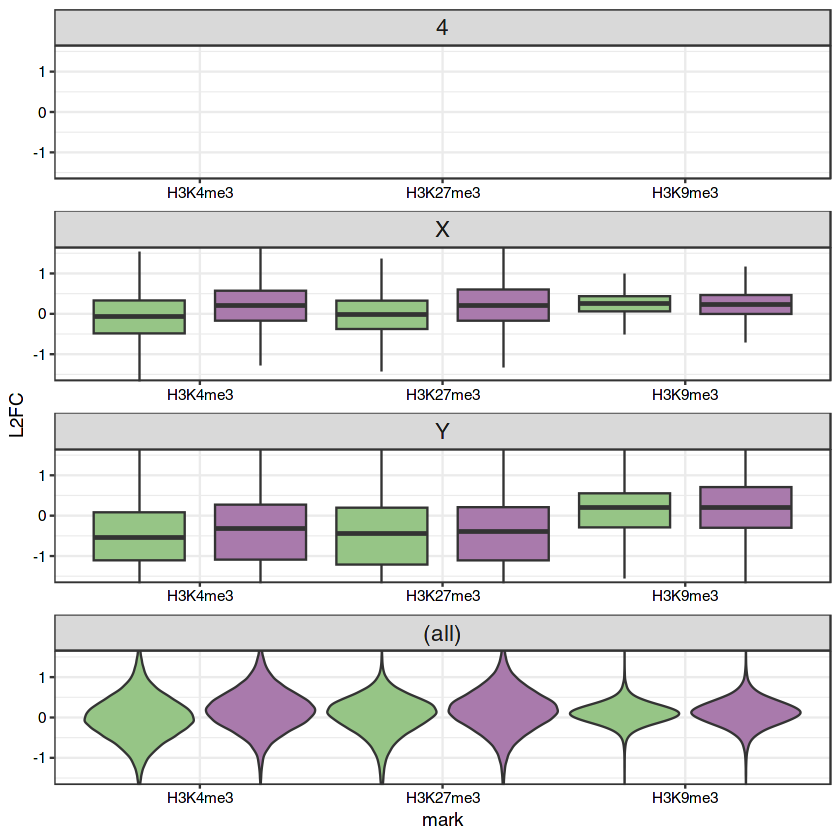

In [50]:
earlier %>%
            `$<-`(
                "data",
                value = subset(
                  data,
                  classification == "GermlineLater"
                ) %>%
                  with(
                    rbind(
                      tibble(mark, L2FC, celltype, seqnames) %>%
                        subset(seqnames %in% c("4", "X", "Y")) %>%
                        mutate(seqnames = seqnames %>% factor(c("4", "X", "Y", "(all)"))),
                      tibble(mark, L2FC, celltype, seqnames) %>%
                        mutate(seqnames = "(all)")
                    )
                  )
            )

png 
  2

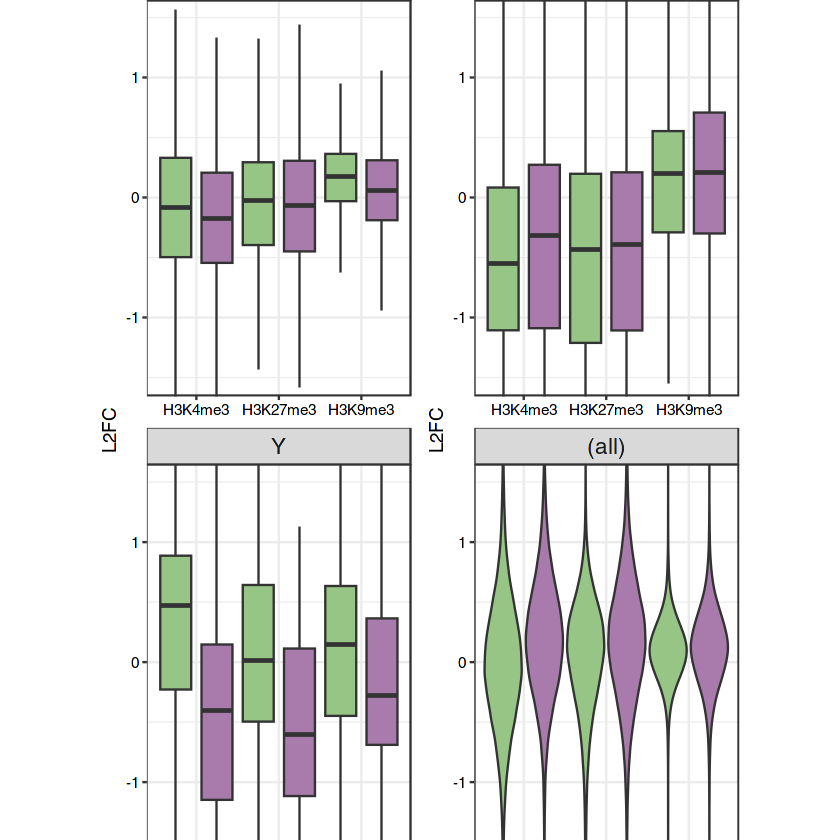

In [51]:
report <- cbind(
    set_panel_size(
        earlier +
            labs(title = "Germline Earlier"),
        w = unit(2.2, "in"),
        h = unit(3.3, "in")
    ),
    set_panel_size(
        earlier %>%
            `$<-`(
                "data",
                value = subset(
                  data,
                  classification == "GermlineLater"
                ) %>%
                  with(
                    rbind(
                      tibble(mark, L2FC, celltype, seqnames) %>%
                        subset(seqnames %in% c("4", "X", "Y")) %>%
                        mutate(seqnames = seqnames %>% droplevels()),
                      tibble(mark, L2FC, celltype, seqnames) %>%
                        mutate(seqnames = "(all)")
                    )
                  )
            ) +
            labs(title = "Germline Later"),
        w = unit(2.2, "in"),
        h = unit(3.3, "in")
    )
)
grid.draw(report)
pdf("figure/Both-Cell-Types/Repli-CHIC-Diff-Rep-Program.pdf", w=8.5, h=17)
grid.draw(report)
dev.off()